In [1]:
#%pip install matplotlib ray
#!pip freeze | grep jax
#%pip install jax==0.3.22 jaxlib==0.3.22+cuda11.cudnn805 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Install and import 

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
import os

In [4]:
from tqdm import tqdm


def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])


def show_ray_progress(res):
    for x in tqdm(to_iterator(res), total=len(res)):
        pass
    return ray.get(res)

In [5]:
workdir = "/work/fukai/basicpy"
os.makedirs(workdir, exist_ok=True)

In [ ]:
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)
import jax

jax.config.update("jax_platform_name", "gpu")

In [ ]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets, metrics
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from os import path
import time
from skimage import filters

plt.rcParams["font.family"] = ""

In [45]:
metrics.fourier_L0_norm?

Signature:
metrics.fourier_L0_norm(
    image: numpy.ndarray,
    threshold: float = 0.1,
    fourier_radius: float = 10,
    exclude_edges: bool = True,
)
Docstring: <no docstring>
File:      ~/.pyenv/versions/miniconda3-4.7.12/envs/basicpy/lib/python3.10/site-packages/basicpy/metrics.py
Type:      function

# Generate test data 

## Make parabola

In [ ]:
def generate_parabola(dim, coef, center):
    sizes = [128] * dim
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1 - c, size // 2 - c, size)
                for (c, size) in zip(center, sizes)
            ],
            indexing="ij"
        )
    )
    gradient = np.sum(grid**2, axis=0)
    gradient = coef * (np.max(gradient) - gradient) + 10
    return gradient / gradient.mean()


# Ground truth, for correctness checking

params = [
    (2, 0.0005, (0, 0)),
    (2, 0.005, (0, 0)),
    (2, 0.0005, (-20, -20)),
    (2, 0.005, (-20, -20)),
]

flatfield_profiles = [generate_parabola(*ps) for ps in params]

for p in flatfield_profiles:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

## Make images with blobs 

aim ... add random (uncorrelated) object that show intensity profile different from the fitted flatfield, see how it affects the fitting quality

In [ ]:
blob_size = 2
blob_dist = lambda: np.random.normal(0, 2)

In [ ]:
def generate_cluttered_images(
    true_flatfield, intensity, n_images, ave_count, blob_dist
):
    poss = np.array(
        [
            [
                np.random.uniform(
                    -size // 2 + 1,
                    size // 2,
                )
                for size in true_flatfield.shape
            ]
            for _ in range(np.random.poisson(ave_count))
        ]
    )

    images = []
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1, size // 2, size)
                for size in true_flatfield.shape
            ],
            indexing="ij"
        )
    )
    for _ in range(n_images):
        image = true_flatfield.copy()
        for p in poss:
            image += (
                np.exp(
                    -np.sum((grid - p[:, np.newaxis, np.newaxis]) ** 2, axis=0)
                    / 2.0
                    / blob_size**2
                )
                / np.sqrt(2 * np.pi * blob_size**2) ** 2
                * blob_dist()
            )
        image = image * intensity
        image = np.clip(image, 0, None)
        image = filters.gaussian(np.random.poisson(image), sigma=1, preserve_range=True)
        images.append(image)
    return np.array(images)

In [ ]:
images = generate_cluttered_images(
    flatfield_profiles[0], 100, 100, 100, lambda: np.random.normal(0, 5)
)
plt.imshow(images[0])
plt.colorbar()

In [ ]:
jax.config.update("jax_platform_name", "gpu")

In [ ]:
b = BaSiC(get_darkfield=False)
b.fit(np.array(images))
plt.subplot(121)
plt.imshow(b.flatfield)
plt.colorbar()
plt.subplot(122)
plt.imshow(b.flatfield / np.mean(b.flatfield) - flatfield_profiles[0])
plt.colorbar()

In [ ]:
plt.imshow(np.median(images, axis=0))

In [ ]:
np.random.seed(202306)
repeat = 100
blob_dists = {
    "unbiased": lambda: np.random.normal(0, 5),
    "biased": lambda: np.random.normal(10, 5),
}
conditions = list(
    product(
        range(
            len(flatfield_profiles)
        ),  # true_flatfield_id (index of flatfield_profiles)
        [10, 100, 1000],  # intensity
        [0, 10, 100],  # ave_count
        [10, 30, 100, 300, 1000],  # n_images
        ["biased", "unbiased"],  # blob_dist_key
        range(5),
    )
)

parameters = []
imagess = []
for (true_flatfield_id, intensity, ave_count, n_images, blob_dist_key, rep) in tqdm(
    conditions
):
    p = {
        "true_flatfield_id": true_flatfield_id,
        "intensity": intensity,
        "ave_count": ave_count,
        "n_images": n_images,
        "blob_dist_key": blob_dist_key,
        "rep": rep,
    }
    parameters.append(p)
    imagess.append(
        generate_cluttered_images(
            flatfield_profiles[true_flatfield_id],
            intensity=intensity,
            n_images=n_images,
            ave_count=ave_count,
            blob_dist=blob_dists[blob_dist_key],
        )
    )

In [ ]:
# show_ray_progress(imagess)

In [ ]:
# imagess = ray.get(imagess)

In [ ]:
with open(path.join(workdir, "wo_darkfield_imagess.pickle"), "wb") as f:
    pickle.dump(imagess, f)

In [ ]:
pd.DataFrame.from_records(parameters).to_csv(
    path.join(workdir, "wo_darkfield_parameters.csv")
)

# Fit images

In [ ]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [ ]:
with open(path.join(workdir, "wo_darkfield_imagess.pickle"), "rb") as f:
    imagess = pickle.load(f)

In [ ]:
!mkdir -p wo_darkfield_imagess

In [ ]:
for j, images in enumerate(imagess):
    np.save(f"wo_darkfield_imagess/{j}.npy", images)

In [ ]:
del imagess

In [ ]:
parameters_df = pd.read_csv(
    path.join(workdir, "wo_darkfield_parameters.csv"), index_col=0
)
# parameters_df = parameters_df.iloc[:900]

In [ ]:
jax.config.update("jax_platform_name", "gpu")

In [ ]:
# parameters_df = pd.DataFrame.from_records(parameters)
# ind = (parameters_df["n_images"]<900).values
# parameters_df2 = parameters_df[ind].copy()
# imagess2 = [imagess[ii] for ii in np.nonzero(ind)[0]]
"""
assert len(parameters_df2) == len(imagess2)
with open("wo_darkfield_imagess2.pickle","wb") as f:
    pickle.dump(imagess2,f)
parameters_df2.to_csv("wo_darkfield_parameters2.csv")
"""

In [ ]:
parameters_df["image_index"] = np.arange(len(parameters_df))

In [ ]:
import warnings

warnings.simplefilter("ignore", DeprecationWarning)

In [ ]:
flatfields = []
baselines = []
b = BaSiC(
    get_darkfield=False,
)
estimated_parameters = []
b_cpu = BaSiC(
    get_darkfield=False,
)

In [36]:
current_num = len(estimated_parameters)
flatfields = flatfields[:current_num]
assert len(flatfields) == current_num

In [37]:
current_num, len(flatfields)

(22145, 22145)

In [46]:
jax.config.update("jax_platform_name", "gpu")
print(jax.devices())
jax.config.update("jax_platform_name", "cpu")

[StreamExecutorGpuDevice(id=0, process_index=0), StreamExecutorGpuDevice(id=1, process_index=0), StreamExecutorGpuDevice(id=2, process_index=0), StreamExecutorGpuDevice(id=3, process_index=0)]


In [ ]:
# q = "true_flatfield_id==0 and ave_count==100 and blob_dist_key=='unbiased'"
_df = parameters_df  # .query(q)
ii = 0

for j, p in tqdm(enumerate(_df.to_dict(orient="records")), total=len(_df)):
    images = np.load(f"wo_darkfield_imagess/{j}.npy")
    #!echo {p["image_index"]} > log.txt
    for fitting_mode, smoothness_flatfield in product(
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-1, 1.5, 7)),  # smoothness_flatfield
    ):
        ii = ii + 1
        if ii <= current_num:
            continue
        p2 = p.copy()
        p2.update(
            {
                "fitting_mode": fitting_mode,
                "smoothness_flatfield": smoothness_flatfield,
            }
        )
        #        query = " and ".join([f"{k}==@p2['{k}']" for k,v in list(p2.items()) if k!= "smoothness_flatfield"])
        #        _df_sel = estimated_parameters_df.query(query)
        #        _row = _df_sel[np.isclose(_df_sel["smoothness_flatfield"],p2["smoothness_flatfield"])]
        #        assert len(_row) == 1

        jax.config.update("jax_platform_name", "gpu")
        jax.config.update("jax_default_device", jax.devices()[1])
        b.fitting_mode = fitting_mode
        b.smoothness_flatfield = smoothness_flatfield
        start = time.time()
        b.fit(images)
        stop = time.time()
        p2["time_gpu"] = stop - start
        flatfields.append(b.flatfield)
        baselines.append(b.baseline)

        jax.config.update("jax_platform_name", "cpu")

        if (
            p["true_flatfield_id"] == 0
            and p["ave_count"] == 100
            and p["blob_dist_key"] == "unbiased"
        ):
            b_cpu.fitting_mode = fitting_mode
            b_cpu.smoothness_flatfield = smoothness_flatfield
            start = time.time()
            b_cpu.fit(images)
            stop = time.time()
            p2["time_cpu"] = stop - start
            assert np.allclose(b_cpu.flatfield, b.flatfield)
            assert np.allclose(b_cpu.baseline, b.baseline)
        else:
            b_cpu.fit(datasets.wsi_brain())

        estimated_parameters.append(p2)

        current_num = len(estimated_parameters)
        assert len(flatfields) == current_num

In [47]:
estimated_parameters_df = pd.DataFrame.from_records(estimated_parameters).reset_index(
    drop=True
)
estimated_parameters_df

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu
0,0,10,0,10,biased,0,0,ladmap,0.100000,12.112859,NaN
1,0,10,0,10,biased,0,0,ladmap,0.261016,1.139761,NaN
2,0,10,0,10,biased,0,0,ladmap,0.681292,1.060643,NaN
3,0,10,0,10,biased,0,0,ladmap,1.778279,1.070440,NaN
4,0,10,0,10,biased,0,0,ladmap,4.641589,0.868617,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22140,3,100,10,300,biased,1,1581,ladmap,31.622777,1.461288,NaN
22141,3,100,10,300,biased,1,1581,approximate,0.100000,6.296663,NaN
22142,3,100,10,300,biased,1,1581,approximate,0.261016,2.620137,NaN
22143,3,100,10,300,biased,1,1581,approximate,0.681292,2.622276,NaN


In [48]:
len(estimated_parameters)

22145

In [49]:
np.save("flatfields.npy", flatfields)

In [50]:
len(flatfields)

22145

In [51]:
estimated_parameters_df

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu
0,0,10,0,10,biased,0,0,ladmap,0.100000,12.112859,NaN
1,0,10,0,10,biased,0,0,ladmap,0.261016,1.139761,NaN
2,0,10,0,10,biased,0,0,ladmap,0.681292,1.060643,NaN
3,0,10,0,10,biased,0,0,ladmap,1.778279,1.070440,NaN
4,0,10,0,10,biased,0,0,ladmap,4.641589,0.868617,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22140,3,100,10,300,biased,1,1581,ladmap,31.622777,1.461288,NaN
22141,3,100,10,300,biased,1,1581,approximate,0.100000,6.296663,NaN
22142,3,100,10,300,biased,1,1581,approximate,0.261016,2.620137,NaN
22143,3,100,10,300,biased,1,1581,approximate,0.681292,2.622276,NaN


# Calculate deviation

In [52]:
flatfields = np.load("flatfields.npy")

In [53]:
assert len(estimated_parameters_df) == len(flatfields)

In [54]:
for (i, row), flatfield in zip(estimated_parameters_df.iterrows(), flatfields):
    estimated_parameters_df.loc[i, "deviation"] = np.mean(
        np.abs(flatfield - flatfield_profiles[row["true_flatfield_id"]])
    )

In [55]:
estimated_parameters_df.to_csv("wo_flatfield_estimated_parameters_df.csv")
estimated_parameters_df.head()

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation
0,0,10,0,10,biased,0,0,ladmap,0.100000,12.112859,NaN,0.024315
1,0,10,0,10,biased,0,0,ladmap,0.261016,1.139761,NaN,0.018550
2,0,10,0,10,biased,0,0,ladmap,0.681292,1.060643,NaN,0.008840
3,0,10,0,10,biased,0,0,ladmap,1.778279,1.070440,NaN,0.005247
4,0,10,0,10,biased,0,0,ladmap,4.641589,0.868617,NaN,0.010590


# Calculate autotune metric

In [56]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df.csv", index_col=0
)
estimated_parameters_df.head()

,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation
0,0,10,0,10,biased,0,0,ladmap,0.100000,12.112859,NaN,0.024315
1,0,10,0,10,biased,0,0,ladmap,0.261016,1.139761,NaN,0.018550
2,0,10,0,10,biased,0,0,ladmap,0.681292,1.060643,NaN,0.008840
3,0,10,0,10,biased,0,0,ladmap,1.778279,1.070440,NaN,0.005247
4,0,10,0,10,biased,0,0,ladmap,4.641589,0.868617,NaN,0.010590


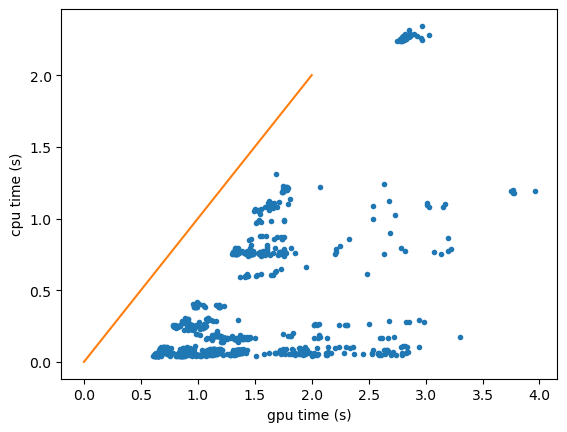

In [59]:
plt.plot(estimated_parameters_df["time_gpu"], estimated_parameters_df["time_cpu"], ".")
plt.xlabel("gpu time (s)")
plt.ylabel("cpu time (s)")
plt.plot([0,2],[0,2])

In [60]:
assert len(flatfields) == len(estimated_parameters_df)

## Calculate histogram ranges 

In [61]:
import ray

ray.shutdown()
ray.init(num_cpus=20)

/home/fukai/.pyenv/versions/miniconda3-4.7.12/envs/basicpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-17 10:28:02,145	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.5.1


In [62]:
histogram_qmin: float = 0.01
histogram_qmax: float = 0.99
vmin_factor: float = 0.6
vrange_factor: float = 1.5
histogram_bins: int = 1000
histogram_use_fitting_weight: bool = True
fourier_l0_norm_image_threshold: float = 0.1
fourier_l0_norm_fourier_radius = 10
fourier_l0_norm_threshold = 1e-3
fourier_l0_norm_cost_coef = 1e4

In [63]:
def calc_vrange(fitting_mode, image_index):
    import warnings

    warnings.simplefilter("ignore", DeprecationWarning)
    b = BaSiC(
        get_darkfield=False,
    )
    images = np.load(f"wo_darkfield_imagess/{int(image_index)}.npy")
    b.fitting_mode = fitting_mode
    b.smoothness_flatfield = 0.1
    b.fit(images)
    transformed = b.transform(images, timelapse=False)
    vmin, vmax = np.quantile(transformed, [histogram_qmin, histogram_qmax])
    val_range = (
        vmax - vmin * vmin_factor
    ) * vrange_factor  # fix the value range for histogram
    return (fitting_mode, image_index), val_range


ress = []
for (fitting_mode, image_index), _ in tqdm(
    list(estimated_parameters_df.groupby(["fitting_mode", "image_index"]))[:]
):
    ress.append(ray.remote(calc_vrange).remote(fitting_mode, image_index))

 21%|████████▏                              | 661/3164 [00:01<00:05, 447.04it/s](calc_vrange pid=173177) 2023-11-17 10:28:04.791531: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(calc_vrange pid=173177) WARNING:absl:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████████████████████████████████| 3164/3164 [00:08<00:00, 367.52it/s]


In [64]:
show_ray_progress(ress);

100%|███████████████████████████████████████| 3164/3164 [43:33<00:00,  1.21it/s]


In [65]:
vranges = dict(ray.get(ress))

In [66]:
with open("vranges.pickle", "wb") as f:
    pickle.dump(vranges, f)

## Calc metrics

In [67]:
with open("vranges.pickle", "rb") as f:
    vranges = pickle.load(f)

In [68]:
ress = []


def calc_autotune_cost(i, row, flatfield):
    images = np.load(f"wo_darkfield_imagess/{int(row['image_index'])}.npy")
    val_range = vranges[(row["fitting_mode"], int(row["image_index"]))]
    b = BaSiC(
        get_darkfield=False,
    )

    b.fitting_mode = row["fitting_mode"]
    b.smoothness_flatfield = row["smoothness_flatfield"]
    b.flatfield = flatfield
    b.darkfield = np.zeros_like(flatfield)
    b.baseline = np.ones(images.shape[0])
    transformed = b.transform(images, timelapse=False)
    entropy_vmin = np.quantile(transformed, histogram_qmin) * vmin_factor
    entropy_vmax = entropy_vmin + val_range
    e = metrics.entropy(
        transformed,
        vmin=entropy_vmin,
        vmax=entropy_vmax,
        bins=histogram_bins,
        clip=True,
    )
    n = metrics.fourier_L0_norm(
        b.flatfield,
        fourier_l0_norm_image_threshold,
        fourier_l0_norm_fourier_radius,
    )
    cost = metrics.autotune_cost(
        transformed,
        flatfield,
        entropy_vmin=entropy_vmin,
        entropy_vmax=entropy_vmax,
        histogram_bins=histogram_bins,
        fourier_l0_norm_cost_coef=fourier_l0_norm_cost_coef,
        fourier_l0_norm_image_threshold=fourier_l0_norm_image_threshold,
        fourier_l0_norm_fourier_radius=fourier_l0_norm_fourier_radius,
        fourier_l0_norm_threshold=fourier_l0_norm_threshold,
    )
    return i, e, n, cost


for (i, row), flatfield in tqdm(
    list(zip(estimated_parameters_df.iterrows(), flatfields))
):
    ress.append(ray.remote(calc_autotune_cost).remote(i, row, flatfield))

100%|█████████████████████████████████████| 22145/22145 [09:42<00:00, 38.00it/s]


In [69]:
show_ray_progress(ress);

100%|████████████████████████████████████| 22145/22145 [01:42<00:00, 215.94it/s]


In [70]:
for i, e, n, cost in ray.get(ress):
    estimated_parameters_df.loc[i, "entropy"] = e
    estimated_parameters_df.loc[i, "fourier_L0_norm"] = n
    estimated_parameters_df.loc[i, "autotune_cost"] = cost

In [71]:
estimated_parameters_df.to_csv("wo_flatfield_estimated_parameters_df_with_autotune.csv")

In [72]:
estimated_parameters_df = pd.read_csv(
    "wo_flatfield_estimated_parameters_df_with_autotune.csv"
)

In [73]:
estimated_parameters_df.query("intensity==1000").head()

,Unnamed: 0,true_flatfield_id,intensity,ave_count,n_images,blob_dist_key,rep,image_index,fitting_mode,smoothness_flatfield,time_gpu,time_cpu,deviation,entropy,fourier_L0_norm,autotune_cost
4200,4200,0,1000,0,10,biased,0,300,ladmap,0.100000,2.112829,NaN,0.002476,3.576117,0.217310,2166.676989
4201,4201,0,1000,0,10,biased,0,300,ladmap,0.261016,0.815523,NaN,0.001917,3.585041,0.078331,776.897619
4202,4202,0,1000,0,10,biased,0,300,ladmap,0.681292,0.625880,NaN,0.001184,3.606114,0.017684,170.442976
4203,4203,0,1000,0,10,biased,0,300,ladmap,1.778279,0.806720,NaN,0.000887,3.632920,0.000374,3.632920
4204,4204,0,1000,0,10,biased,0,300,ladmap,4.641589,0.804044,NaN,0.001620,3.662640,0.000000,3.662640


In [74]:
assert all(estimated_parameters_df.index == np.arange(len(estimated_parameters_df)))

  0%|                                                     | 0/6 [00:00<?, ?it/s]

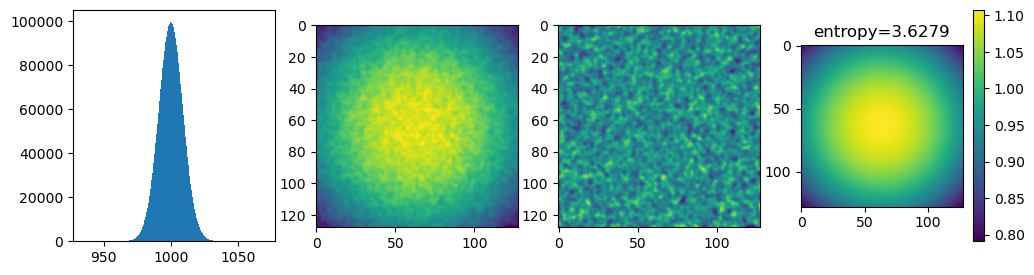

 17%|███████▌                                     | 1/6 [00:02<00:13,  2.78s/it]

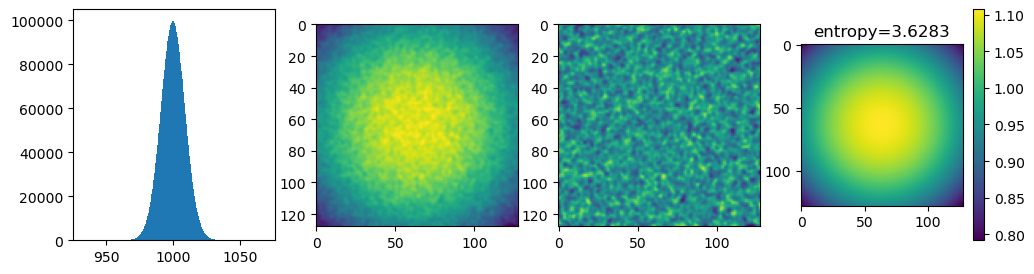

 33%|███████████████                              | 2/6 [00:05<00:10,  2.66s/it]

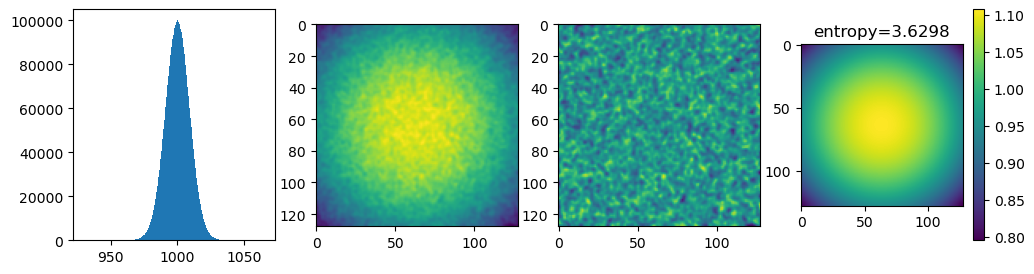

 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.60s/it]

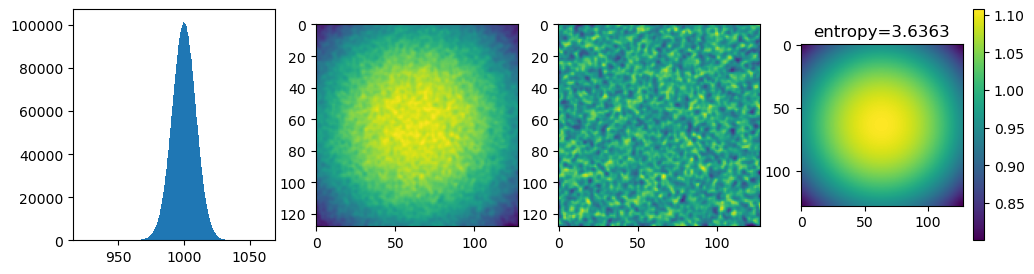

 67%|██████████████████████████████               | 4/6 [00:10<00:05,  2.56s/it]

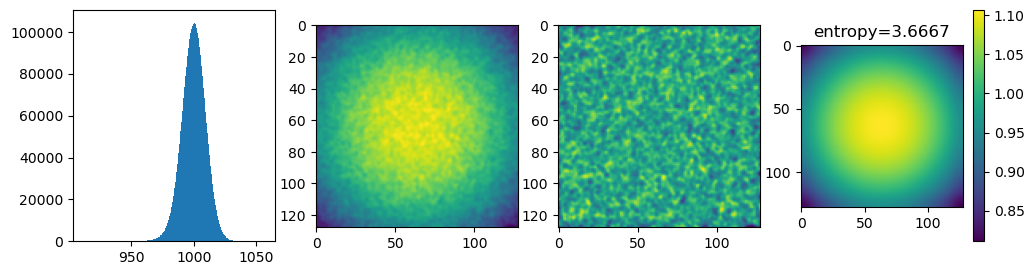

 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.52s/it]

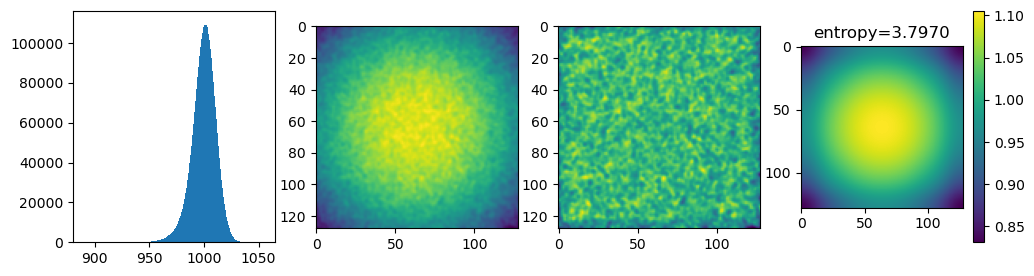

100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]


In [75]:
for (i, row) in tqdm(
    list(
        estimated_parameters_df.query(
            "intensity==1000 and n_images==1000 and ave_count==0"
        ).iterrows()
    )[:6]
):
    flatfield = flatfields[i]
    images = np.load(f"wo_darkfield_imagess/{int(row['image_index'])}.npy")
    val_range = vranges[(row["fitting_mode"], int(row["image_index"]))]
    b = BaSiC(
        get_darkfield=False,
    )

    b.fitting_mode = row["fitting_mode"]
    b.smoothness_flatfield = row["smoothness_flatfield"]
    b.flatfield = flatfield
    b.darkfield = np.zeros_like(flatfield)
    b.baseline = np.ones(images.shape[0])
    transformed = images / flatfield[np.newaxis]  # b.transform(images, timelapse=False)
    entropy_vmin = np.quantile(transformed, histogram_qmin) * vmin_factor
    entropy_vmax = entropy_vmin + val_range
    e = metrics.entropy(
        transformed,
        vmin=entropy_vmin,
        vmax=entropy_vmax,
        bins=histogram_bins,
        clip=True,
    )
    plt.figure(figsize=(12, 3))
    plt.subplot(141)
    # plt.hist(transformed.flatten(),bins=histogram_bins,range=(entropy_vmin,entropy_vmax))
    plt.hist(transformed.flatten(), bins=histogram_bins)  # ,range=(900,1100))
    plt.subplot(142)
    plt.imshow(images[0])
    plt.subplot(143)
    plt.imshow(transformed[0])
    plt.subplot(144)
    plt.imshow(flatfield)
    plt.colorbar()
    plt.title(f"entropy={e:.4f}")
    plt.show()

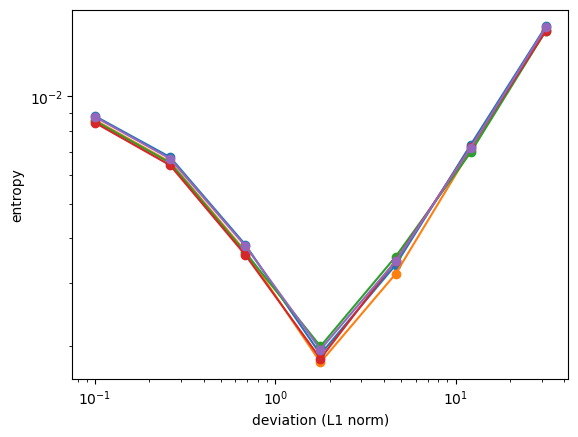

In [76]:
keys = [
    "true_flatfield_id",
    "intensity",
    "ave_count",
    "n_images",
    "blob_dist_key",
    "fitting_mode",
]
for vals, grp in estimated_parameters_df.groupby(keys):
    if vals[3] < 100:
        continue
    for rep, grp2 in grp.groupby("rep"):
        plt.plot(grp2["smoothness_flatfield"], grp2["deviation"], "o-")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("deviation (L1 norm)")
    plt.ylabel("entropy")
    break
    # plt.ylim(1.2,1.6)
plt.show()

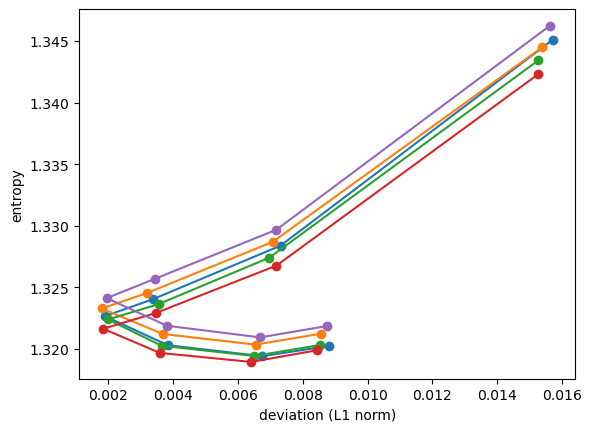

In [77]:
keys = [
    "true_flatfield_id",
    "intensity",
    "ave_count",
    "n_images",
    "blob_dist_key",
    "fitting_mode",
]
for vals, grp in estimated_parameters_df.groupby(keys):
    if vals[3] < 100:
        continue
    for rep, grp2 in grp.groupby("rep"):
        plt.plot(grp2["deviation"], grp2["entropy"], "o-")
    # plt.yscale("log")
    plt.xlabel("deviation (L1 norm)")
    plt.ylabel("entropy")
    # plt.ylim(1.2,1.6)
    plt.show()
    break